### The solution has been divided into two parts.
Part 1: Deriving the business insights that are useful for product development and marketing.

Part 2: Creating a sentiment classification engine.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing libraries to read to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# importing libraries for text analytics
import nltk
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
pd.set_option('max_colwidth', 100)
from sklearn.feature_extraction.text import TfidfVectorizer
import re


# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve


import warnings
warnings.filterwarnings('ignore')

### The following data sets are available
1.   meta data of type .json
2.   phone data of type .csv

The meta data holds information from sellers point of view and the phone data holds user information.
We begin by unzipping the meta data file and extracting its content to a list



# Reading the  data



In [3]:
#Reading the .csv file of the phone data into a dataframe

df_phonedata = pd.read_csv('/content/drive/My Drive/Cell_Phones_and_Accessories_5.csv')

In [4]:
df_phonedata.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_sentiment
0,5.0,True,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not drop your phone so often because the rhinestones ...,Can't stop won't stop looking at it,1407110400,NaN,NaN,POSITIVE
1,5.0,True,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy...,1,1392163200,NaN,NaN,POSITIVE
2,3.0,True,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too notice...",Its okay,1391817600,NaN,NaN,NEGATIVE
3,2.0,True,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,1391472000,NaN,NaN,POSITIVE
4,4.0,True,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would ...",Cute!,1391385600,NaN,NaN,POSITIVE


In [5]:
# Reading the meta data
# importing libraries

import gzip
import shutil

# Path to the meta data zip file.
path1 = '/content/drive/My Drive/meta_Cell_Phones_and_Accessories.json.gz'

# Path to meta data .json file
path2 = '/content/drive/My Drive/meta_Cell_Phones_and_Accessories.json'

# Unzipping the meta data file
with gzip.open(path1, 'rb') as f_in:
     with open(path2, 'wb') as f_out:
         shutil.copyfileobj(f_in, f_out)

In [6]:
# Reading the unzipped meta data into a Python list. The result will be a list of dictionaries.
import json

# Empty list to store the dictonaries
phonemetadata = []

# Reading the dictionaries in the json file and appending it to the list phonemetadata[]
with open(path2, 'r') as f:
     for line in f:
         phonemetadata.append(json.loads(line))

In [7]:
# converting the list phonemetadata into a data frame
df_meta = pd.DataFrame(phonemetadata)

In [8]:
# need only cellphone 'category'
df_meta["new_category"] = [l[1] if len(l) > 0 else np.nan for l in df_meta["category"]]

In [9]:
cellphone_data = df_meta[df_meta["new_category"] == "Cell Phones"]

In [10]:
# converting to csv file and storing it as cellphone only data
# cellphone_data.to_csv('/content/drive/My Drive/cellphone_data.csv',escapechar='\\')

In [11]:
cellphone_data.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,new_category
36,"[Cell Phones & Accessories, Cell Phones, Unlocked Cell Phones]",,"[ICE CENIOR *SENIOR PHONE*, QUAD BAND Super big keyboard, Helpful Emergency call dial key -SOS-,...",,UNLOCKED DUAL SIM SLOT *CENIOR PHONE* QUAD BAND *WORLD PHONE* GSM CELL PHONE WHITE,[],"[https://images-na.ssl-images-amazon.com/images/I/41%2BgmCg3XpL._SX38_SY50_CR,0,0,38,50_.jpg, ht...",,Ice,"[2G NETWORK, Quad Band: GSM 850/900/1800/1900 MHZ, Dual SIM cards dual standby Super big keyboar...","[>#6,356,920 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#32,868 i...",[],{},Cell Phones & Accessories,,,,8050110508,Cell Phones
1274,"[Cell Phones & Accessories, Cell Phones, Unlocked Cell Phones]",,[Standard package: 1 x original phone 1 x Quality battery 1 x New charger 1 x Box],,Nokia 3310 Blue Nokia,"[B075FL4H89, B00R25GJJW]","[https://images-na.ssl-images-amazon.com/images/I/41PM889JFWL._SS40_.jpg, https://images-na.ssl-...",,Nokia,"[GSM 900/1800, Simple and elegant, Classic model, Small, handy, easy to use]","[>#32,759 in Electronics (See Top 100 in Electronics), >#1,430 in Electronics > Cell Phones & Ac...","[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,...",{},All Electronics,"class=""a-bordered a-horizontal-stripes a-spacing-extra-large a-size-base comparison_table"">\n\...","October 19, 2014",,B00005KBGR,Cell Phones
1295,"[Cell Phones & Accessories, Cell Phones]",,"[The Nokia 5180i is a handset offered by TracFone, a leading national prepaid service provider. ...",,Nokia 5180i TracFone Prepaid Cell Phone with 10 FREE MINUTES,[],"[https://images-na.ssl-images-amazon.com/images/I/31N85ZGWP6L._SX38_SY50_CR,0,0,38,50_.jpg, http...",,Nokia,[],[],[],{},Cell Phones & Accessories,,,,B00005S0M4,Cell Phones
1354,"[Cell Phones & Accessories, Cell Phones, Carrier Cell Phones]",,"[Based on Motorola&#x92;s i90c phone, the i95cl offers some valuable upgrades that increase the ...",,Motorola i95cl Phone (Nextel),[],"[https://images-na.ssl-images-amazon.com/images/I/41Z5GT0W86L._SX38_SY50_CR,0,0,38,50_.jpg, http...",,,[],"[>#3,798,962 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#4,421 in...",[],{},Cell Phones & Accessories,,,,B00006J9HH,Cell Phones
1361,"[Cell Phones & Accessories, Cell Phones, Carrier Cell Phones]",,[This is a GSM Samsung R225 cellular phone that was activated through T-Mobile.This is ONLY comp...,,T-Mobile Dual-Band Wireless Phone,[],"[https://images-na.ssl-images-amazon.com/images/I/4137ET4GRXL._SX38_SY50_CR,0,0,38,50_.jpg, http...",,Samsung,[],"[>#5,552,033 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#5,268 in...",[],{},Cell Phones & Accessories,,,,B00006LIQB,Cell Phones


# Data pre-processing



In [12]:
df_phonedata.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_sentiment
0,5.0,True,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not drop your phone so often because the rhinestones ...,Can't stop won't stop looking at it,1407110400,NaN,NaN,POSITIVE
1,5.0,True,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy...,1,1392163200,NaN,NaN,POSITIVE
2,3.0,True,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too notice...",Its okay,1391817600,NaN,NaN,NEGATIVE
3,2.0,True,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,1391472000,NaN,NaN,POSITIVE
4,4.0,True,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would ...",Cute!,1391385600,NaN,NaN,POSITIVE


In [13]:
# checking df shape
df_phonedata.shape

(1128437, 12)

In [14]:
# info of the dataset
df_phonedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   overall           1128437 non-null  float64
 1   verified          1128437 non-null  bool   
 2   reviewerID        1128437 non-null  object 
 3   asin              1128437 non-null  object 
 4   style             605241 non-null   object 
 5   reviewerName      1128235 non-null  object 
 6   reviewText        1127607 non-null  object 
 7   summary           1127898 non-null  object 
 8   unixReviewTime    1128437 non-null  int64  
 9   vote              92034 non-null    object 
 10  image             27107 non-null    object 
 11  review_sentiment  1128437 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 95.8+ MB


In [15]:
# numerical feature description of df
df_phonedata.describe()

,overall,unixReviewTime
count,1.128437e+06,1.128437e+06
mean,4.221383e+00,1.440400e+09
std,1.231917e+00,4.569215e+07
min,1.000000e+00,1.035331e+09
25%,4.000000e+00,1.416355e+09
50%,5.000000e+00,1.444349e+09
75%,5.000000e+00,1.470442e+09
max,5.000000e+00,1.538438e+09


In [16]:
# extracting the vote feature along with related asin for analysis
user_votes = df_phonedata[['asin', 'vote']]
user_votes

,asin,vote
0,7508492919,NaN
1,7508492919,NaN
2,7508492919,NaN
3,7508492919,NaN
4,7508492919,NaN
...,...,...
1128432,B01HJC7N4C,NaN
1128433,B01HJC7N4C,NaN
1128434,B01HJC7N4C,NaN
1128435,B01HJC7N4C,NaN


In [17]:
# counting different types of asin values
len(df_phonedata['asin'].value_counts())

48186

In [18]:
# calculating percent of null values for each column
def null_values(df):
    nulls = pd.DataFrame(columns=['features','percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            percent = round(df[col].isna().sum()/len(df.index)*100, 2)
            nulls.loc[len(nulls)] = {'features' : col, 'percentage' : percent}
    return nulls

In [19]:
null_values(df_phonedata)

,features,percentage
0,style,46.36
1,reviewerName,0.02
2,reviewText,0.07
3,summary,0.05
4,vote,91.84
5,image,97.60


In [20]:
# we will fill null values of vote column to 0
df_phonedata['vote'].fillna(0,inplace=True)

In [21]:
# dropping the columns style and image
df_phonedata.drop(columns=['style', 'image'], axis=1, inplace=True)

##### "reviewText" is a neccesary column to sentiment anaylsis, hence we are removing the rows with null values

In [22]:
# removing the rows with null values
df_phonedata = df_phonedata[df_phonedata['reviewText'].notna()]

In [23]:
# converting unixReview time into date time format
from datetime import datetime, timedelta
df_phonedata['Date_Time'] = df_phonedata['unixReviewTime'].apply(lambda d: (datetime.fromtimestamp(d) - timedelta(hours=2)).strftime('%Y-%m-%d'))

Checking the meta data frame with only cellphone data

In [24]:
cellphone_data.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,new_category
36,"[Cell Phones & Accessories, Cell Phones, Unlocked Cell Phones]",,"[ICE CENIOR *SENIOR PHONE*, QUAD BAND Super big keyboard, Helpful Emergency call dial key -SOS-,...",,UNLOCKED DUAL SIM SLOT *CENIOR PHONE* QUAD BAND *WORLD PHONE* GSM CELL PHONE WHITE,[],"[https://images-na.ssl-images-amazon.com/images/I/41%2BgmCg3XpL._SX38_SY50_CR,0,0,38,50_.jpg, ht...",,Ice,"[2G NETWORK, Quad Band: GSM 850/900/1800/1900 MHZ, Dual SIM cards dual standby Super big keyboar...","[>#6,356,920 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#32,868 i...",[],{},Cell Phones & Accessories,,,,8050110508,Cell Phones
1274,"[Cell Phones & Accessories, Cell Phones, Unlocked Cell Phones]",,[Standard package: 1 x original phone 1 x Quality battery 1 x New charger 1 x Box],,Nokia 3310 Blue Nokia,"[B075FL4H89, B00R25GJJW]","[https://images-na.ssl-images-amazon.com/images/I/41PM889JFWL._SS40_.jpg, https://images-na.ssl-...",,Nokia,"[GSM 900/1800, Simple and elegant, Classic model, Small, handy, easy to use]","[>#32,759 in Electronics (See Top 100 in Electronics), >#1,430 in Electronics > Cell Phones & Ac...","[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,...",{},All Electronics,"class=""a-bordered a-horizontal-stripes a-spacing-extra-large a-size-base comparison_table"">\n\...","October 19, 2014",,B00005KBGR,Cell Phones
1295,"[Cell Phones & Accessories, Cell Phones]",,"[The Nokia 5180i is a handset offered by TracFone, a leading national prepaid service provider. ...",,Nokia 5180i TracFone Prepaid Cell Phone with 10 FREE MINUTES,[],"[https://images-na.ssl-images-amazon.com/images/I/31N85ZGWP6L._SX38_SY50_CR,0,0,38,50_.jpg, http...",,Nokia,[],[],[],{},Cell Phones & Accessories,,,,B00005S0M4,Cell Phones
1354,"[Cell Phones & Accessories, Cell Phones, Carrier Cell Phones]",,"[Based on Motorola&#x92;s i90c phone, the i95cl offers some valuable upgrades that increase the ...",,Motorola i95cl Phone (Nextel),[],"[https://images-na.ssl-images-amazon.com/images/I/41Z5GT0W86L._SX38_SY50_CR,0,0,38,50_.jpg, http...",,,[],"[>#3,798,962 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#4,421 in...",[],{},Cell Phones & Accessories,,,,B00006J9HH,Cell Phones
1361,"[Cell Phones & Accessories, Cell Phones, Carrier Cell Phones]",,[This is a GSM Samsung R225 cellular phone that was activated through T-Mobile.This is ONLY comp...,,T-Mobile Dual-Band Wireless Phone,[],"[https://images-na.ssl-images-amazon.com/images/I/4137ET4GRXL._SX38_SY50_CR,0,0,38,50_.jpg, http...",,Samsung,[],"[>#5,552,033 in Cell Phones & Accessories (See Top 100 in Cell Phones & Accessories), >#5,268 in...",[],{},Cell Phones & Accessories,,,,B00006LIQB,Cell Phones


In [25]:
# checking info
cellphone_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9823 entries, 36 to 590019
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      9823 non-null   object
 1   tech1         9823 non-null   object
 2   description   9823 non-null   object
 3   fit           9823 non-null   object
 4   title         9823 non-null   object
 5   also_buy      9823 non-null   object
 6   image         9823 non-null   object
 7   tech2         9823 non-null   object
 8   brand         9823 non-null   object
 9   feature       9823 non-null   object
 10  rank          9823 non-null   object
 11  also_view     9823 non-null   object
 12  details       9823 non-null   object
 13  main_cat      9823 non-null   object
 14  similar_item  9823 non-null   object
 15  date          9823 non-null   object
 16  price         9823 non-null   object
 17  asin          9823 non-null   object
 18  new_category  9823 non-null   object
dtypes: objec

In [26]:
# dropping category column as we have already created a new column new_category based on cell phones
cellphone_data.drop('category', axis=1, inplace= True)

In [27]:
# Checking for duplicate asin in metadata
len(cellphone_data[cellphone_data.duplicated('asin')])

34

In [28]:
# dropping the duplicates as only unique asin should exist
cellphone_data = cellphone_data.drop_duplicates(subset=['asin'])

##### 'Price' is an important feature, hence we will impute the missing values

In [29]:
cellphone_data['price'].value_counts()

price
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [30]:
# imputing values where price having descriptive text
cellphone_data["price"]=[np.nan if len(str(x))>15 else x for x in cellphone_data["price"]]

In [31]:
cellphone_data['price'].value_counts()

price
           8046
$40.08      133
$27.57      129
$16.00       44
$49.99       38
           ... 
$159.06       1
$82.00        1
$272.98       1
$37.28        1
$75.24        1
Name: count, Length: 723, dtype: int64

In [32]:
# replacing the '$' to none, ',' to none and also converting price to float data type
cellphone_data['price']= cellphone_data['price'].str.replace("$",'')
cellphone_data['price']= cellphone_data['price'].str.replace(",",'')
cellphone_data['price']= pd.to_numeric(cellphone_data['price'], errors='coerce')

In [33]:
# checking the overall nulls of price column
cellphone_data["price"].isnull().sum()

8092

In [34]:
# checking brand wise null values of price
cellphone_data[cellphone_data["price"].isnull()]['brand'].value_counts()

brand
Samsung         1209
LG               616
Motorola         591
Nokia            452
BLU              440
                ... 
Social Drive       1
MYSAGA             1
GoPro              1
LSoug              1
BEISTE             1
Name: count, Length: 874, dtype: int64

In [35]:
# imputing null values of price with the brand's average price
cellphone_data['price'] = cellphone_data['price'].fillna(cellphone_data.groupby('brand')['price'].transform('mean'))

In [36]:
# dropping unneccesary columns
cellphone_data.drop(columns=['fit', 'tech2', 'tech1', 'date', 'similar_item','main_cat','image'], axis=1, inplace=True)

In [37]:
cellphone_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 36 to 590019
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   description   9789 non-null   object 
 1   title         9789 non-null   object 
 2   also_buy      9789 non-null   object 
 3   brand         9789 non-null   object 
 4   feature       9789 non-null   object 
 5   rank          9789 non-null   object 
 6   also_view     9789 non-null   object 
 7   details       9789 non-null   object 
 8   price         7731 non-null   float64
 9   asin          9789 non-null   object 
 10  new_category  9789 non-null   object 
dtypes: float64(1), object(10)
memory usage: 917.7+ KB


In [38]:
# extracting rank in cellphones and acessories
cellphone_data['new_rank'] = cellphone_data['rank'].astype(str).str.extract(pat='([^>#](\d{0,3},)?(\d{3},)?\d{0,3}\s*in Cell Phones & Accessories)')[0]

In [39]:
cellphone_data['new_rank'] = cellphone_data['new_rank'].str.replace(">#","").str.replace("in Cell Phones & Accessories","").str.replace(",","")

In [40]:
# converting new rank column to numeric type
cellphone_data['new_rank'] = cellphone_data['new_rank'].astype('float')

In [41]:
cellphone_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 36 to 590019
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   description   9789 non-null   object 
 1   title         9789 non-null   object 
 2   also_buy      9789 non-null   object 
 3   brand         9789 non-null   object 
 4   feature       9789 non-null   object 
 5   rank          9789 non-null   object 
 6   also_view     9789 non-null   object 
 7   details       9789 non-null   object 
 8   price         7731 non-null   float64
 9   asin          9789 non-null   object 
 10  new_category  9789 non-null   object 
 11  new_rank      9400 non-null   float64
dtypes: float64(2), object(10)
memory usage: 994.2+ KB


In [42]:
# dropping the original 'rank' column as we have created 'new_rank' column
cellphone_data.drop(["rank"], axis=1, inplace=True)

In [43]:
cellphone_data.head()

,description,title,also_buy,brand,feature,also_view,details,price,asin,new_category,new_rank
36,"[ICE CENIOR *SENIOR PHONE*, QUAD BAND Super big keyboard, Helpful Emergency call dial key -SOS-,...",UNLOCKED DUAL SIM SLOT *CENIOR PHONE* QUAD BAND *WORLD PHONE* GSM CELL PHONE WHITE,[],Ice,"[2G NETWORK, Quad Band: GSM 850/900/1800/1900 MHZ, Dual SIM cards dual standby Super big keyboar...",[],{},NaN,8050110508,Cell Phones,6356920.0
1274,[Standard package: 1 x original phone 1 x Quality battery 1 x New charger 1 x Box],Nokia 3310 Blue Nokia,"[B075FL4H89, B00R25GJJW]",Nokia,"[GSM 900/1800, Simple and elegant, Classic model, Small, handy, easy to use]","[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,...",{},92.513680,B00005KBGR,Cell Phones,NaN
1295,"[The Nokia 5180i is a handset offered by TracFone, a leading national prepaid service provider. ...",Nokia 5180i TracFone Prepaid Cell Phone with 10 FREE MINUTES,[],Nokia,[],[],{},92.513680,B00005S0M4,Cell Phones,NaN
1354,"[Based on Motorola&#x92;s i90c phone, the i95cl offers some valuable upgrades that increase the ...",Motorola i95cl Phone (Nextel),[],,[],[],{},140.100556,B00006J9HH,Cell Phones,3798962.0
1361,[This is a GSM Samsung R225 cellular phone that was activated through T-Mobile.This is ONLY comp...,T-Mobile Dual-Band Wireless Phone,[],Samsung,[],[],{},117.247465,B00006LIQB,Cell Phones,5552033.0


'also_view' column shows other brands also viewed by the customer, lets convert this feature into a list

In [46]:
cellphone_data = cellphone_data.assign(also_view_new=cellphone_data.also_view.astype(str).str.replace('[','').str.replace(']','').str.replace(' ','').str.replace('\'',"").str.split(','))

In [47]:
# function to derive brand name from the list of also_view column

def get_also_view_brand(l):
    brand_list = []
    brand = ''
    for i in range(0,len(l)):
        temp = cellphone_data[cellphone_data['asin']==l[i]]['brand']

        if len(temp)>0:
            brand = temp.values[0]
            if brand not in brand_list:
                brand_list.append(brand)
    return brand_list

In [48]:
cellphone_data.head()

,description,title,also_buy,brand,feature,also_view,details,price,asin,new_category,new_rank,also_view_new
36,"[ICE CENIOR *SENIOR PHONE*, QUAD BAND Super big keyboard, Helpful Emergency call dial key -SOS-,...",UNLOCKED DUAL SIM SLOT *CENIOR PHONE* QUAD BAND *WORLD PHONE* GSM CELL PHONE WHITE,[],Ice,"[2G NETWORK, Quad Band: GSM 850/900/1800/1900 MHZ, Dual SIM cards dual standby Super big keyboar...",[],{},NaN,8050110508,Cell Phones,6356920.0,[]
1274,[Standard package: 1 x original phone 1 x Quality battery 1 x New charger 1 x Box],Nokia 3310 Blue Nokia,"[B075FL4H89, B00R25GJJW]",Nokia,"[GSM 900/1800, Simple and elegant, Classic model, Small, handy, easy to use]","[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,...",{},92.513680,B00005KBGR,Cell Phones,NaN,"[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,..."
1295,"[The Nokia 5180i is a handset offered by TracFone, a leading national prepaid service provider. ...",Nokia 5180i TracFone Prepaid Cell Phone with 10 FREE MINUTES,[],Nokia,[],[],{},92.513680,B00005S0M4,Cell Phones,NaN,[]
1354,"[Based on Motorola&#x92;s i90c phone, the i95cl offers some valuable upgrades that increase the ...",Motorola i95cl Phone (Nextel),[],,[],[],{},140.100556,B00006J9HH,Cell Phones,3798962.0,[]
1361,[This is a GSM Samsung R225 cellular phone that was activated through T-Mobile.This is ONLY comp...,T-Mobile Dual-Band Wireless Phone,[],Samsung,[],[],{},117.247465,B00006LIQB,Cell Phones,5552033.0,[]


In [49]:
# getting the unique brand details from also_view
cellphone_data['also_view_brand'] =[get_also_view_brand(l) if len(l) > 0 else np.nan for l in cellphone_data["also_view_new"]]

In [50]:
# dropping the 'also_view' column
cellphone_data.drop('also_view', axis=1, inplace=True)

In [51]:
cellphone_data.head()

,description,title,also_buy,brand,feature,details,price,asin,new_category,new_rank,also_view_new,also_view_brand
36,"[ICE CENIOR *SENIOR PHONE*, QUAD BAND Super big keyboard, Helpful Emergency call dial key -SOS-,...",UNLOCKED DUAL SIM SLOT *CENIOR PHONE* QUAD BAND *WORLD PHONE* GSM CELL PHONE WHITE,[],Ice,"[2G NETWORK, Quad Band: GSM 850/900/1800/1900 MHZ, Dual SIM cards dual standby Super big keyboar...",{},NaN,8050110508,Cell Phones,6356920.0,[],[]
1274,[Standard package: 1 x original phone 1 x Quality battery 1 x New charger 1 x Box],Nokia 3310 Blue Nokia,"[B075FL4H89, B00R25GJJW]",Nokia,"[GSM 900/1800, Simple and elegant, Classic model, Small, handy, easy to use]",{},92.513680,B00005KBGR,Cell Phones,NaN,"[B075FL4H89, B075FKZMR2, B00TLWTJLO, B0757B64H2, B00851Q9L0, B076BVNGZQ, B07BTG3T3Y, B0172EEAQQ,...","[Nokia, Caterpillar, BLU, Fsmart, ZTE, Higoo]"
1295,"[The Nokia 5180i is a handset offered by TracFone, a leading national prepaid service provider. ...",Nokia 5180i TracFone Prepaid Cell Phone with 10 FREE MINUTES,[],Nokia,[],{},92.513680,B00005S0M4,Cell Phones,NaN,[],[]
1354,"[Based on Motorola&#x92;s i90c phone, the i95cl offers some valuable upgrades that increase the ...",Motorola i95cl Phone (Nextel),[],,[],{},140.100556,B00006J9HH,Cell Phones,3798962.0,[],[]
1361,[This is a GSM Samsung R225 cellular phone that was activated through T-Mobile.This is ONLY comp...,T-Mobile Dual-Band Wireless Phone,[],Samsung,[],{},117.247465,B00006LIQB,Cell Phones,5552033.0,[],[]


### Merging Dataframe for further analysis

In [53]:
# Merging both dataframe, one with phoneData and the other with the reviews
# will be using innerjoin to merge the dataframes
df_merged = pd.merge(df_phonedata, cellphone_data, how='inner', on=['asin'])

In [54]:
df_merged.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_sentiment,...,title,also_buy,brand,feature,details,price,new_category,new_rank,also_view_new,also_view_brand
0,1.0,False,A5JLAU2ARJ0BO,B0000E3GWH,Old-and-Wise,This phone is ugly and heavy and has a terrible user interface even for techies like myself. It...,Bad reception,1095724800,2.0,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[],[]
1,4.0,False,A1ACM1CBGORBN1,B0000E3GWH,Sherry Berry,I had the Samsung V205 and then I decided to try the E715 out. FYI to people with battery proble...,Pretty good phone.. an improvement from my v205,1090627200,15.0,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[],[]
2,3.0,False,A2V48Q03FZUOSD,B0000E3GWH,Benjamin David,This is the first Samsung phone I have had and it does not quite measure-up to the V300. I am a...,Not as user friendly as the Motorola V300-,1089072000,11.0,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[],[]
3,5.0,True,A1V3TRGWOMA8LC,B0000E3GWH,James Beswick,"..and I'm from Europe, where the phones and networks are much better than in the States. I have ...",The best phone I've ever owned,1081728000,4.0,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[],[]
4,3.0,False,A3NOBH42C7UI5M,B0000E3GWH,Kepela,This phone is amazingly small and light for a camera phone; it even has a flashlight/flash. Prob...,I love the phone but it has some real problems,1077148800,12.0,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[],[]


In [55]:
# saving the file in the drive
# df_merged.to_csv("/content/drive/My Drive/df_merged.csv",escapechar='\\')

In [56]:
# lets now change datatype of boolean columns to integer (true=1, false=0)
df_merged['verified'].replace({False: 0, True: 1}, inplace=True)

In [57]:
# copying merged df for converting into excel file
df_merged1 = df_merged.copy()

In [58]:
# removing IllegalCodeError due for unicode error
df_merged1 = df_merged1.applymap(lambda x: x.encode('unicode_escape').decode('utf-8') if isinstance(x, str) else x)

In [59]:
# convert to xlsx format and save in drive
df_merged1.to_excel(r'/content/drive/My Drive/merged_excelfile.xlsx', index=False, header=True)

In [60]:
len(df_merged)

63834

#### Checking review sentiment counts in the data

In [61]:
# counting positive and negative entries
pos_neg = df_merged.review_sentiment.value_counts()
pos_neg

review_sentiment
POSITIVE    47677
NEGATIVE    16157
Name: count, dtype: int64

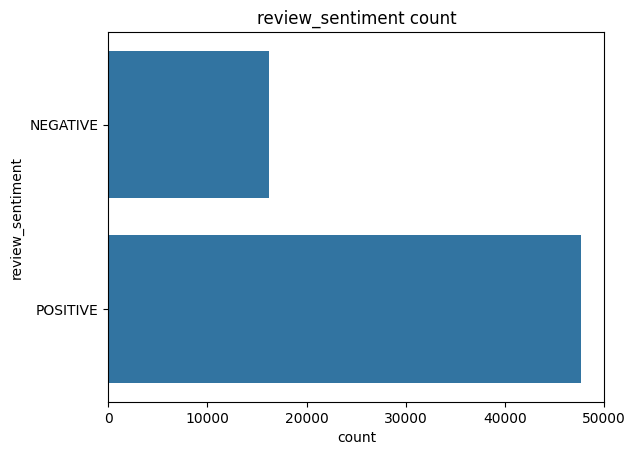

In [62]:
# plotting to observe the distribution
plt.title('review_sentiment count')
sns.countplot(df_merged['review_sentiment'])
plt.show()

In [64]:
# checking number of positive and negative reviews along with their percent share
neg  = pos_neg[1]
pos  = pos_neg[0]

print('Number of negative reviews: ', neg, end='\n')
print('Number of positive reviews: ', pos, end='\n')
print('Negative review rate is approx {0}%'.format(round((neg/float(pos+neg))*100), 2),end='\n')
print('positve review rate is approx {0}%'.format(round((pos/float(pos+neg))*100), 2))

Number of negative reviews:  16157
Number of positive reviews:  47677
Negative review rate is approx 25%
positve review rate is approx 75%


Data is very much imbalance and it is more in favour of positive

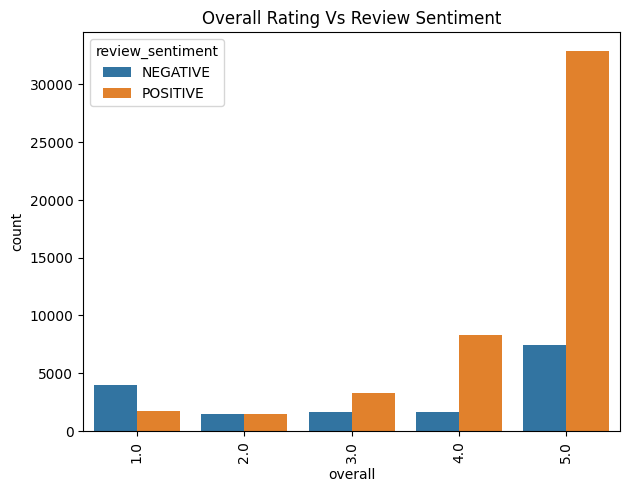

In [65]:
# let us analyse positive and negative reviews distributed along the ratings
plt.figure()
sns.countplot(data=df_merged, x=df_merged['overall'], hue=df_merged['review_sentiment'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Overall Rating Vs Review Sentiment')
plt.show()

From the above plot, everything seems to be normal. As expected, most of the positive reviews have higher rating and negative reviews have lower rating.

In [66]:
# lets observe top 10 brands by review counts
df_merged['brand'].value_counts()[:10]

brand
Samsung       16193
BLU            9326
LG             6657
Motorola       4922
Nokia          4885
Apple          4049
BlackBerry     3656
HTC            2453
Sony           1556
Huawei         1401
Name: count, dtype: int64

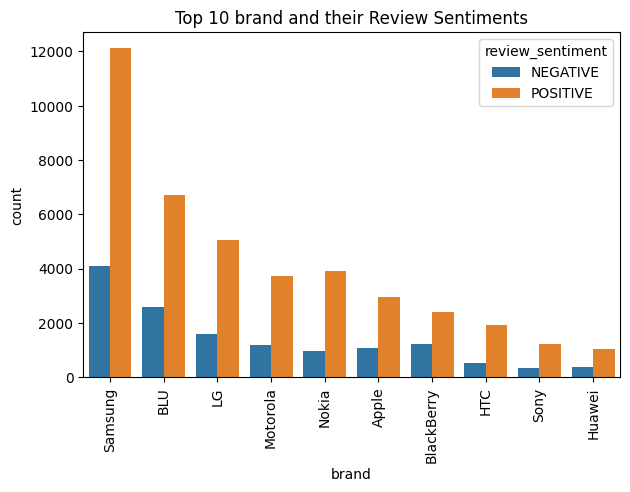

In [67]:
plt.figure()
sns.countplot(data=df_merged, x=df_merged['brand'], hue=df_merged['review_sentiment'], order=df_merged['brand'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Top 10 brand and their Review Sentiments')
plt.show()

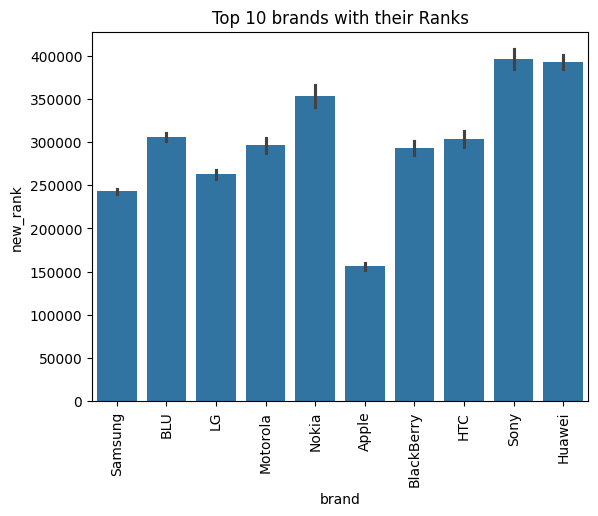

In [69]:
# top 10 brands with their ranks in cellphone category
plt.figure()
sns.barplot(data=df_merged, x=df_merged['brand'], y=df_merged['new_rank'], order=df_merged['brand'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title("Top 10 brands with their Ranks")
plt.show()

##### Let us now analyse the verified reviews

In [70]:
df_merged["verified"].value_counts()

verified
1    54990
0     8844
Name: count, dtype: int64

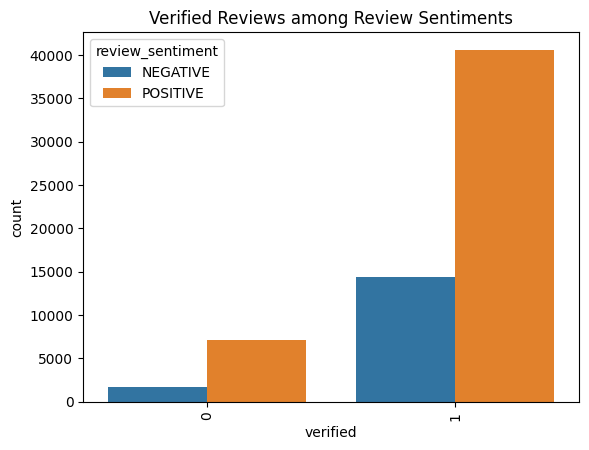

In [71]:
plt.figure()
sns.countplot(data=df_merged, x=df_merged['verified'], hue=df_merged['review_sentiment'])
plt.xticks(rotation=90)
plt.title('Verified Reviews among Review Sentiments')
plt.show()

So, majority of the reviews are verified

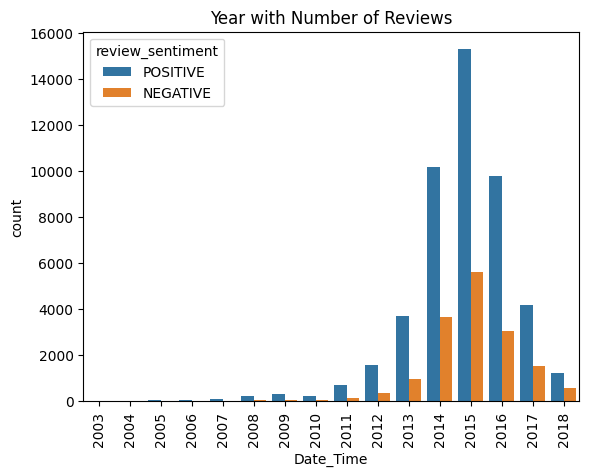

In [73]:
# observing reviews accumilated over the years
plt.figure()
sns.countplot(data=df_merged, x=pd.DatetimeIndex(df_merged['Date_Time']).year, hue=df_merged['review_sentiment'])
plt.xticks(rotation=90)
plt.title("Year with Number of Reviews")
plt.show()

Most of the reviews are between 2014-2016, the trend increased until this period and reduced post that.

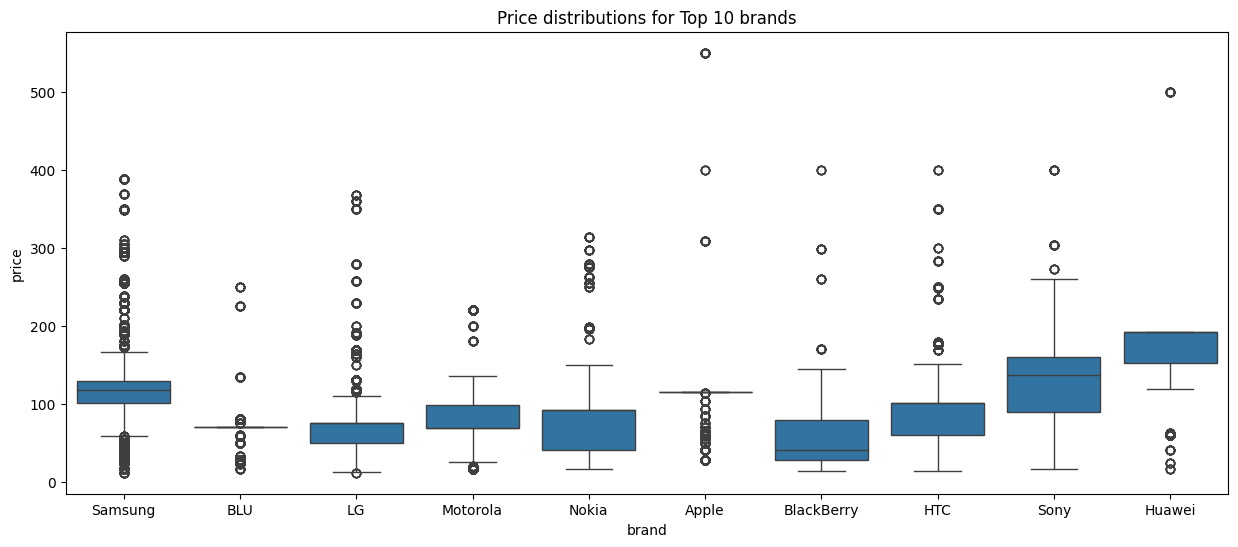

In [74]:
# top 10 brands along with their price distribution
plt.figure(figsize=[15,6])
plt.title("Price distributions for Top 10 brands")
sns.boxplot(data=df_merged, x='brand', y='price', order=df_merged['brand'].value_counts().iloc[:10].index)
plt.show()

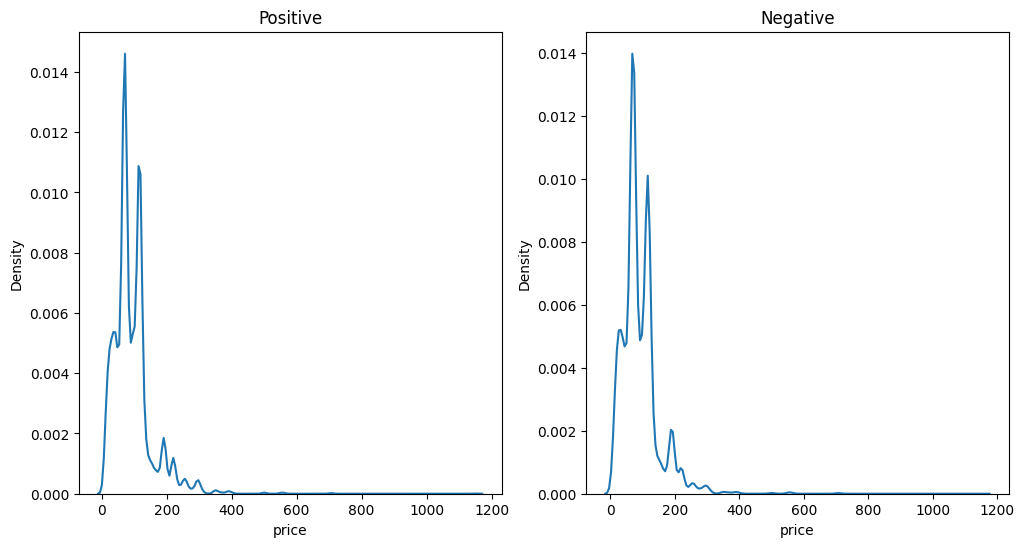

In [75]:
# price wise distribution for review sentiments
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title='Positive')
ax2 = fig.add_subplot(1, 2, 2, title='Negative')

sns.kdeplot(df_merged[df_merged['review_sentiment'] == 'POSITIVE']['price'], ax=ax1)
sns.kdeplot(df_merged[df_merged['review_sentiment'] == 'NEGATIVE']['price'], ax=ax2)

plt.show()

# Text Analytics

In [76]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [77]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [78]:
# Reading stop words from a text file in to a list
stop_words = [line.rstrip('\n') for line in open('/content/drive/My Drive/stop_words_long.txt')]

Lets start by removing stop words, we will be using the custom list of stop words provided, to avoid removing 'no', 'not', etc.. words as they will be important for review analysis. We will also be removing the punctuations and numbers from the text.

#### Defining functions to remove stop words, positive words, negative words and puncuations words

In [79]:
# function to remove stop words
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(document):
    # changing the text to lower case
    document = document.lower()
    # tokenizing into words
    words = word_tokenize(document)
    # removing stop words
    words = [word for word in words if word not in stop_words]
    # including only the words whose length is greater than 2
    words = [w for w in words if len(w)>2]
    # joining the words to make it back into text
    document = " ".join(words)

    return document

In [80]:
# function to remove positive/negative words
def remove_words(document):
    # tokenizing into words
    words = word_tokenize(document)
    # removing positive/negative words
    words = [word for word in words if word not in positive_words]
    words = [word for word in words if word not in negative_words]
    document = " ".join(words)

    return document

In [81]:
# function to remove punctuations
def remove_punctuations(text):
    text = re.sub('[^A-Za-z]+', ' ', text)

    return text

In [82]:
# applying lemmatization
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def apply_lemmatization(document):
    # tokenize into words and change into lower case
    document = document.lower()
    words = word_tokenize(document)
    # removing stop words
    words = [word for word in words if word not in stop_words]
    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    words=[w for w in words if len(w)>2]
    # joining words back into text
    document = " ".join(words)

    return document

#### To Preprocess text for Tableau Visualisation

In [83]:
# making a new dataframe with only reviews and sentiment
df_review = df_merged[['reviewText','review_sentiment']]

In [84]:
df_review['review_text_nostop'] = [preprocess(x) for x in df_review['reviewText']]

In [85]:
df_review['review_text_nostop']

0        phone ugly heavy terrible user interface techies like drops calls like crazy manhattan moto v600...
1        samsung v205 decided try e715 fyi people battery problems batteries drain completely charge like...
2        samsung phone not measure-up v300 tmobile customer finally fed v300 terrible camera tmobile sent...
3        europe phones networks better samsung currently best software huge nokia fan amazingly light int...
4        phone amazingly light camera phone flashlight/flash problems phone real problem battery life wor...
                                                        ...                                                 
63829                                             phone stolen not activate told comes stolen n't appreciate
63830                                                                                                   good
63831       purchased problems finally tossed screens glitching disappointing samsung usually great products
63832              

In [86]:
# Reading positive words from the text file in drive into a list
positive_words = [line.rstrip('\n') for line in open('/content/drive/My Drive/pos_words.txt')]

In [87]:
# Reading negative words from the text file in drive into a list
negative_words = [line.rstrip('\n') for line in open('/content/drive/My Drive/neg_words.txt')]

In [88]:
# removing punctuations
df_review['review_text_nostop'] = df_review['review_text_nostop'].apply(remove_punctuations)

In [89]:
# even after the removal of punctuation marks,there are still some stop words, hence using the above function to remove the remaining stopwords and performing lemmatization.
df_review['review_text_nostop'] = [apply_lemmatization(x) for x in df_review['review_text_nostop']]

In [90]:
df_review['review_text_nostop']

0        phone ugly heavy terrible user interface techies like drop call like crazy manhattan moto better...
1        samsung decide try fyi people battery problems batteries drain completely charge like build batt...
2        samsung phone not measure tmobile customer finally feed terrible camera tmobile send upgrade goo...
3        europe phone network better samsung currently best software huge nokia fan amazingly light intui...
4        phone amazingly light camera phone flashlight flash problems phone real problem battery life wor...
                                                        ...                                                 
63829                                                    phone steal not activate tell come steal appreciate
63830                                                                                                   good
63831              purchase problems finally toss screen glitching disappoint samsung usually great products
63832              

In [91]:
# dividing the positive and negative reviews to different dfs to create word clouds in Tableau
df_positive = df_review[df_review['review_sentiment']=='POSITIVE'][['review_text_nostop','review_sentiment']]
df_negative = df_review[df_review['review_sentiment']=='NEGATIVE'][['review_text_nostop','review_sentiment']]

In [92]:
df_positive.head()

,review_text_nostop,review_sentiment
1,samsung decide try fyi people battery problems batteries drain completely charge like build batt...,POSITIVE
3,europe phone network better samsung currently best software huge nokia fan amazingly light intui...,POSITIVE
4,phone amazingly light camera phone flashlight flash problems phone real problem battery life wor...,POSITIVE
5,see explosion nice color phone market functionalities similar extra bonus bell whistle sell prod...,POSITIVE
6,receive treo friday treocentral service sprint test compare sprint coverage against mobile veriz...,POSITIVE


In [93]:
df_negative.head()

,review_text_nostop,review_sentiment
0,phone ugly heavy terrible user interface techies like drop call like crazy manhattan moto better...,NEGATIVE
2,samsung phone not measure tmobile customer finally feed terrible camera tmobile send upgrade goo...,NEGATIVE
12,frank high expectations treo read time lead release actual disappoint front deserve star usable ...,NEGATIVE
22,chicago gps work yes window dozens time surround suburbs work miles north chicago not break unfo...,NEGATIVE
23,not forum people express unhappiness believe reality sprint nextel service problems service rela...,NEGATIVE


In [94]:
# preparing for the files, for exporting file into Tableau
neg_sentiment_features = df_negative[['review_text_nostop']]
pos_sentiment_features = df_positive[['review_text_nostop']]

In [95]:
pos_sentiment_features.head()

,review_text_nostop
1,samsung decide try fyi people battery problems batteries drain completely charge like build batt...
3,europe phone network better samsung currently best software huge nokia fan amazingly light intui...
4,phone amazingly light camera phone flashlight flash problems phone real problem battery life wor...
5,see explosion nice color phone market functionalities similar extra bonus bell whistle sell prod...
6,receive treo friday treocentral service sprint test compare sprint coverage against mobile veriz...


In [96]:
neg_sentiment_features.head()

,review_text_nostop
0,phone ugly heavy terrible user interface techies like drop call like crazy manhattan moto better...
2,samsung phone not measure tmobile customer finally feed terrible camera tmobile send upgrade goo...
12,frank high expectations treo read time lead release actual disappoint front deserve star usable ...
22,chicago gps work yes window dozens time surround suburbs work miles north chicago not break unfo...
23,not forum people express unhappiness believe reality sprint nextel service problems service rela...


In [97]:
lst_pos= [str(w).split(" ") for w in pos_sentiment_features["review_text_nostop"]]
lst_neg= [str(w).split(" ") for w in neg_sentiment_features["review_text_nostop"]]

In [98]:
# trying to flatten the lists
import itertools
merged_pos = list(itertools.chain(*lst_pos))
merged_neg = list(itertools.chain(*lst_neg))

In [99]:
print(len(merged_pos))
merged_pos

1850581


['samsung',
 'decide',
 'try',
 'fyi',
 'people',
 'battery',
 'problems',
 'batteries',
 'drain',
 'completely',
 'charge',
 'like',
 'build',
 'battery',
 'life',
 'time',
 'improve',
 'battery',
 'life',
 'immensely',
 'mobile',
 'customer',
 'stay',
 'customer',
 'service',
 'great',
 'rate',
 'plan',
 'work',
 'great',
 'additional',
 'feature',
 'little',
 'gadget',
 'caller',
 'pics',
 'able',
 'external',
 'display',
 'flip',
 'person',
 'camera',
 'flash',
 'well',
 'zoom',
 'able',
 'picture',
 'gray',
 'black',
 'white',
 'negative',
 'sepia',
 'sketch',
 'multi',
 'shoot',
 'well',
 'lot',
 'frame',
 'picture',
 'download',
 'game',
 'whereas',
 'not',
 'furthermore',
 'game',
 'actually',
 'java',
 'flash',
 'serve',
 'flashlight',
 'useful',
 'sometimes',
 'walk',
 'light',
 'pretty',
 'bright',
 'voice',
 'memo',
 'nuf',
 'otherwise',
 'usual',
 'feature',
 'alarm',
 'calculator',
 'calendar',
 'list',
 'mms',
 'sms',
 'download',
 'ringtones',
 'help',
 'ringtones',
 's

In [100]:
print(len(merged_neg))
merged_neg

254325


['phone',
 'ugly',
 'heavy',
 'terrible',
 'user',
 'interface',
 'techies',
 'like',
 'drop',
 'call',
 'like',
 'crazy',
 'manhattan',
 'moto',
 'better',
 'phone',
 'take',
 'better',
 'picture',
 'better',
 'clarity',
 'reception',
 'cheaper',
 'moto',
 'mobile',
 'stay',
 'ugly',
 'monster',
 'samsung',
 'phone',
 'not',
 'measure',
 'tmobile',
 'customer',
 'finally',
 'feed',
 'terrible',
 'camera',
 'tmobile',
 'send',
 'upgrade',
 'good',
 'feature',
 'phone',
 'external',
 'antenna',
 'brake',
 'camera',
 'take',
 'better',
 'picture',
 'comfortable',
 'bad',
 'phone',
 'sound',
 'quality',
 'call',
 'receiver',
 'tinny',
 'sound',
 'digital',
 'unlike',
 'not',
 'realize',
 'good',
 'receive',
 'phone',
 'lack',
 'feature',
 'maybe',
 'spoil',
 'phone',
 'not',
 'technology',
 'phone',
 'example',
 'phone',
 'not',
 'easy',
 'datebook',
 'set',
 'alarm',
 'remind',
 'appointments',
 'not',
 'speakerphone',
 'work',
 'well',
 'handy',
 'time',
 'simply',
 'like',
 'commodore'

In [101]:
# creating dataframes from the lists
df_pos = pd.DataFrame({'col':merged_pos})
df_neg = pd.DataFrame({'col':merged_neg})

In [102]:
# these two file will be saved and used in tableau file

# df_pos.to_csv('/content/drive/My Drive/pos_sentiment_word.csv')
# df_neg.to_csv('/content/drive/My Drive/neg_sentiment_word.csv')

### Bag of Words Model

In [103]:
from sklearn.feature_extraction.text import CountVectorizer

#### Bag of words model for positive reviews

In [104]:
positive_reviews= [message for message in pos_sentiment_features['review_text_nostop']]

In [105]:
# bag of words model
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(positive_reviews)
print(bow_model)

  (0, 20273)	1
  (0, 5673)	1
  (0, 24301)	1
  (0, 9275)	1
  (0, 17049)	1
  (0, 2068)	3
  (0, 18187)	2
  (0, 2066)	1
  (0, 6726)	1
  (0, 4470)	1
  (0, 3736)	1
  (0, 13312)	2
  (0, 3073)	1
  (0, 13265)	2
  (0, 23733)	2
  (0, 11435)	1
  (0, 11353)	1
  (0, 14764)	1
  (0, 5398)	2
  (0, 22232)	1
  (0, 20775)	1
  (0, 9977)	3
  (0, 18869)	1
  (0, 17518)	1
  (0, 26500)	1
  :	:
  (47676, 10674)	2
  (47676, 1572)	1
  (47676, 13644)	1
  (47676, 13341)	2
  (47676, 8377)	1
  (47676, 6004)	1
  (47676, 14685)	1
  (47676, 15760)	1
  (47676, 4057)	1
  (47676, 15813)	1
  (47676, 6023)	1
  (47676, 21471)	1
  (47676, 16332)	1
  (47676, 3759)	1
  (47676, 10347)	2
  (47676, 7470)	1
  (47676, 13078)	1
  (47676, 15786)	1
  (47676, 481)	1
  (47676, 4756)	1
  (47676, 13085)	1
  (47676, 2525)	1
  (47676, 9301)	2
  (47676, 16778)	1
  (47676, 22258)	1


In [107]:
# viewing them as a dataframe
pd.DataFrame(bow_model.toarray(), columns = vectorizer.get_feature_names_out())

,aaa,aaaa,aaaaa,aaaaammmmaaaaazzzziiiiinnnngggg,aaahs,aac,aacute,aadverts,aall,aand,...,zwh,zxs,zyb,zyeqgses,zynga,zywwhu,zyxel,zzg,zzodc,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# printing the model shape
print(bow_model.shape)

(47677, 27039)


In [110]:
# printing the vocabulary
vectorizer.vocabulary_

{'samsung': 20273,
 'decide': 5673,
 'try': 24301,
 'fyi': 9275,
 'people': 17049,
 'battery': 2068,
 'problems': 18187,
 'batteries': 2066,
 'drain': 6726,
 'completely': 4470,
 'charge': 3736,
 'like': 13312,
 'build': 3073,
 'life': 13265,
 'time': 23733,
 'improve': 11435,
 'immensely': 11353,
 'mobile': 14764,
 'customer': 5398,
 'stay': 22232,
 'service': 20775,
 'great': 9977,
 'rate': 18869,
 'plan': 17518,
 'work': 26500,
 'additional': 321,
 'feature': 8353,
 'little': 13413,
 'gadget': 9280,
 'caller': 3296,
 'pics': 17385,
 'able': 38,
 'external': 8066,
 'display': 6410,
 'flip': 8707,
 'person': 17166,
 'camera': 3319,
 'flash': 8641,
 'well': 26080,
 'zoom': 27007,
 'picture': 17393,
 'gray': 9967,
 'black': 2460,
 'white': 26189,
 'negative': 15441,
 'sepia': 20733,
 'sketch': 21244,
 'multi': 15123,
 'shoot': 20953,
 'lot': 13605,
 'frame': 8990,
 'download': 6677,
 'game': 9321,
 'whereas': 26158,
 'not': 15779,
 'furthermore': 9243,
 'actually': 271,
 'java': 12364,


In [111]:
pos_vocabular = pd.DataFrame.from_dict(vectorizer.vocabulary_,orient='index')

In [112]:
pos_vocabular

,0
samsung,20273
decide,5673
try,24301
fyi,9275
people,17049
...,...
rampant,18832
officials,16086
formable,8889
deservedly,5971


#### Bag of words model for negative reviews

In [113]:
negative_reviews= [message for message in neg_sentiment_features['review_text_nostop']]

In [114]:
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(negative_reviews)
print(bow_model)

  (0, 7527)	2
  (0, 10806)	2
  (0, 4667)	1
  (0, 10326)	1
  (0, 11104)	1
  (0, 5299)	1
  (0, 10225)	1
  (0, 5805)	2
  (0, 2977)	1
  (0, 1362)	1
  (0, 2195)	1
  (0, 6093)	1
  (0, 6533)	2
  (0, 962)	3
  (0, 10162)	1
  (0, 7562)	1
  (0, 1663)	1
  (0, 8343)	1
  (0, 1549)	1
  (0, 6434)	1
  (0, 9837)	1
  (0, 6495)	1
  (1, 7527)	12
  (1, 10326)	1
  (1, 11104)	1
  :	:
  (16150, 6440)	1
  (16151, 6497)	1
  (16151, 8794)	1
  (16151, 9885)	1
  (16151, 11241)	1
  (16152, 4381)	1
  (16152, 3486)	1
  (16153, 5415)	1
  (16153, 8744)	1
  (16154, 7527)	1
  (16154, 6841)	2
  (16154, 9486)	1
  (16154, 5938)	1
  (16154, 4040)	1
  (16154, 9995)	1
  (16154, 9323)	1
  (16154, 8320)	1
  (16155, 7527)	1
  (16155, 6841)	1
  (16155, 1781)	1
  (16155, 10288)	1
  (16155, 113)	1
  (16155, 9843)	2
  (16155, 529)	1
  (16156, 3486)	1


In [116]:
neg_words=vectorizer.get_feature_names_out()
print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out())

11795
['aaa' 'aaaaa' 'aaaaaa' ... 'zut' 'zxcvbnm' 'zydc']


In [117]:
# print the vocabulary
vectorizer.vocabulary_

{'phone': 7527,
 'ugly': 10806,
 'heavy': 4667,
 'terrible': 10326,
 'user': 11104,
 'interface': 5299,
 'techies': 10225,
 'like': 5805,
 'drop': 2977,
 'call': 1362,
 'crazy': 2195,
 'manhattan': 6093,
 'moto': 6533,
 'better': 962,
 'take': 10162,
 'picture': 7562,
 'clarity': 1663,
 'reception': 8343,
 'cheaper': 1549,
 'mobile': 6434,
 'stay': 9837,
 'monster': 6495,
 'samsung': 8959,
 'not': 6841,
 'measure': 6180,
 'tmobile': 10524,
 'customer': 2294,
 'finally': 3823,
 'feed': 3769,
 'camera': 1378,
 'send': 9164,
 'upgrade': 11059,
 'good': 4338,
 'feature': 3760,
 'external': 3638,
 'antenna': 457,
 'brake': 1170,
 'comfortable': 1788,
 'bad': 778,
 'sound': 9653,
 'quality': 8143,
 'receiver': 8337,
 'tinny': 10497,
 'digital': 2701,
 'unlike': 10948,
 'realize': 8297,
 'receive': 8336,
 'lack': 5635,
 'maybe': 6164,
 'spoil': 9735,
 'technology': 10238,
 'example': 3468,
 'easy': 3084,
 'datebook': 2366,
 'set': 9213,
 'alarm': 280,
 'remind': 8554,
 'appointments': 528,
 '

In [118]:
neg_vocabular = pd.DataFrame.from_dict(vectorizer.vocabulary_,orient='index')

In [119]:
neg_vocabular

,0
phone,7527
ugly,10806
heavy,4667
terrible,10326
user,11104
...,...
slowwwwww,9493
guyana,4512
imagination,4985
mobo,6440


##### Completed Data pre-processing, EDA and Text Analytics as Part 1 and prepared necessary files including csv file for Tableau dashboard and Wordcloud.